# Explorando o Poder do BERT e GPT-2
Este notebook é uma exploração profunda das capacidades de modelos avançados de linguagem, como BERT e GPT-2, aplicados em tarefas essenciais de Processamento de Linguagem Natural (PLN). Vamos navegar por técnicas de classificação de textos, modelagem de tópicos e geração de texto, descobrindo como esses modelos podem transformar a análise de linguagem por meio de embeddings semânticos e fine-tuning criativo.

---

## Índice

1. [Classificação de Textos com DistilBERT](#classificacao-distilbert)
   - Uso de embeddings do DistilBERT para a tarefa de classificação de textos.
   - Comparação de resultados entre diferentes classificadores.
2. [Modelagem de Tópicos com BERTopic](#modelagem-bertopic)
   - Extração e visualização de tópicos utilizando a técnica BERTopic.
   - Análise das palavras mais relevantes para cada tópico e visualizações gráficas.
3. [Engenharia de Prompt para Extração de Entidades Nomeadas](#engenharia-prompt)
   - Desenvolvimento de prompts específicos para identificação de entidades em grandes modelos de linguagem.
   - Demonstração com exemplos práticos e análise dos resultados.
4. [Fine-tuning com GPT-2 para Geração de Textos](#fine-tuning-gpt2)
   - Procedimento de fine-tuning do GPT-2 com uma base de textos personalizada.
   - Geração de textos a partir de tags ou palavras iniciais fornecidas.

## <a name="classificacao-distilbert"></a>1. Classificação de Textos com DistilBERT

Nesta análise, utilizamos embeddings gerados pelo **DistilBERT** — uma versão compacta do modelo BERT — para realizar a tarefa de classificação de textos. A abordagem inclui o uso de três classificadores distintos para explorar como diferentes modelos podem se beneficiar dos embeddings e como isso afeta a acurácia da classificação. Este estudo permite avaliar o DistilBERT como uma ferramenta eficiente para extração de características semânticas em tarefas de classificação.

**Conteúdos Abordados:**
- Embeddings de textos com DistilBERT.
- Implementação da classificação com diferentes algoritmos.
- Comparação de desempenho e análise dos resultados obtidos.

In [5]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from dotenv import load_dotenv
import torch
import transformers as trf
from bertopic import BERTopic
from bertopic.representation import (KeyBERTInspired, MaximalMarginalRelevance,
                                     PartOfSpeech)
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from torch.utils.data import DataLoader, TensorDataset
from umap import UMAP

warnings.filterwarnings('ignore')
batch_size = 8

In [3]:
bbc_df = pd.read_csv('../data/bbc_data.csv')
bbc_df

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment
...,...,...
2220,Warning over Windows Word files Writing a Mic...,tech
2221,Fast lifts rise into record books Two high-sp...,tech
2222,Nintendo adds media playing to DS Nintendo is...,tech
2223,Fast moving phone viruses appear Security fir...,tech


In [5]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (trf.DistilBertModel, trf.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [16]:
# Tokenize with DistilBERT
tokenized = bbc_df["data"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)))
tokenized

0       [101, 5389, 2000, 11147, 2149, 2417, 6823, 538...
1       [101, 23343, 2015, 4792, 2000, 2022, 2193, 202...
2       [101, 24779, 23798, 1999, 2006, 1011, 2754, 29...
3       [101, 1055, 13542, 3388, 13284, 2149, 3482, 24...
4       [101, 17401, 4376, 11217, 3482, 2436, 17401, 4...
                              ...                        
2220    [101, 5432, 2058, 3645, 2773, 6764, 3015, 1037...
2221    [101, 3435, 13695, 4125, 2046, 2501, 2808, 204...
2222    [101, 10022, 9909, 2865, 2652, 2000, 16233, 10...
2223    [101, 3435, 3048, 3042, 18191, 3711, 3036, 978...
2224    [101, 23307, 5081, 2000, 18108, 11943, 5198, 1...
Name: data, Length: 2225, dtype: object

In [17]:
# Padding with zeros
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [18]:
# Masking
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2225, 512)

In [19]:

input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

dataset = TensorDataset(input_ids, attention_mask)
dataloader = DataLoader(dataset, batch_size=batch_size)

# Processar em batches
all_hidden_states = []
with torch.no_grad():
    for batch in dataloader:
        batch_input_ids, batch_attention_mask = batch
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        all_hidden_states.append(outputs.last_hidden_state)

# Combinar resultados se necessário
final_hidden_states = torch.cat(all_hidden_states, dim=0)

In [23]:
final_hidden_states.shapessws

torch.Size([2225, 512, 768])

In [31]:
# get CLS token
features = final_hidden_states[:,0,:].numpy()
print(features)
# get labels
labels = bbc_df['labels']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

[[ 0.10110058 -0.19566427 -0.01884099 ...  0.05212193  0.44286123
   0.09798598]
 [ 0.11865637  0.06662822 -0.05111479 ...  0.0783582   0.54244214
   0.13095109]
 [-0.06782479 -0.22566284  0.00254339 ...  0.14256424  0.30843654
   0.07328955]
 ...
 [-0.6104803  -0.26726165  0.37968096 ... -0.03576938  0.4247782
   0.29779458]
 [-0.12818824 -0.13537686 -0.02083402 ...  0.02009162  0.31604028
   0.53772044]
 [-0.3197346   0.09743609 -0.08297192 ... -0.0350312   0.23754647
   0.46788716]]


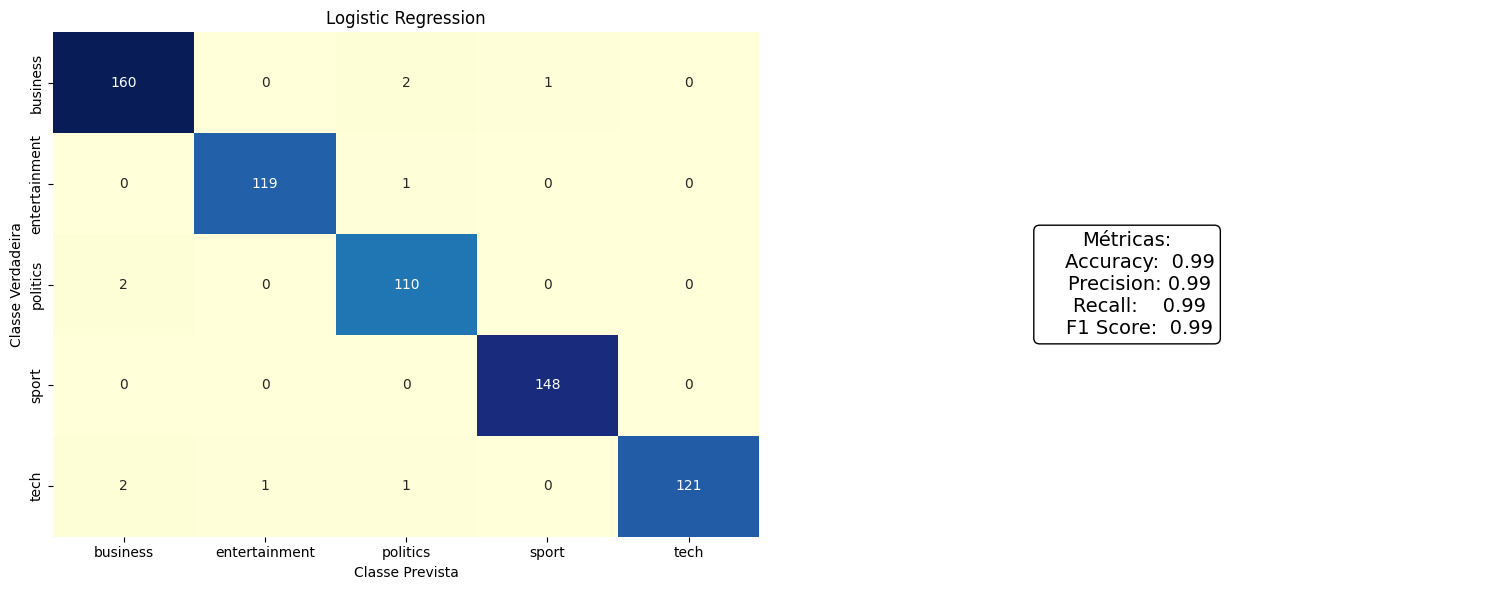

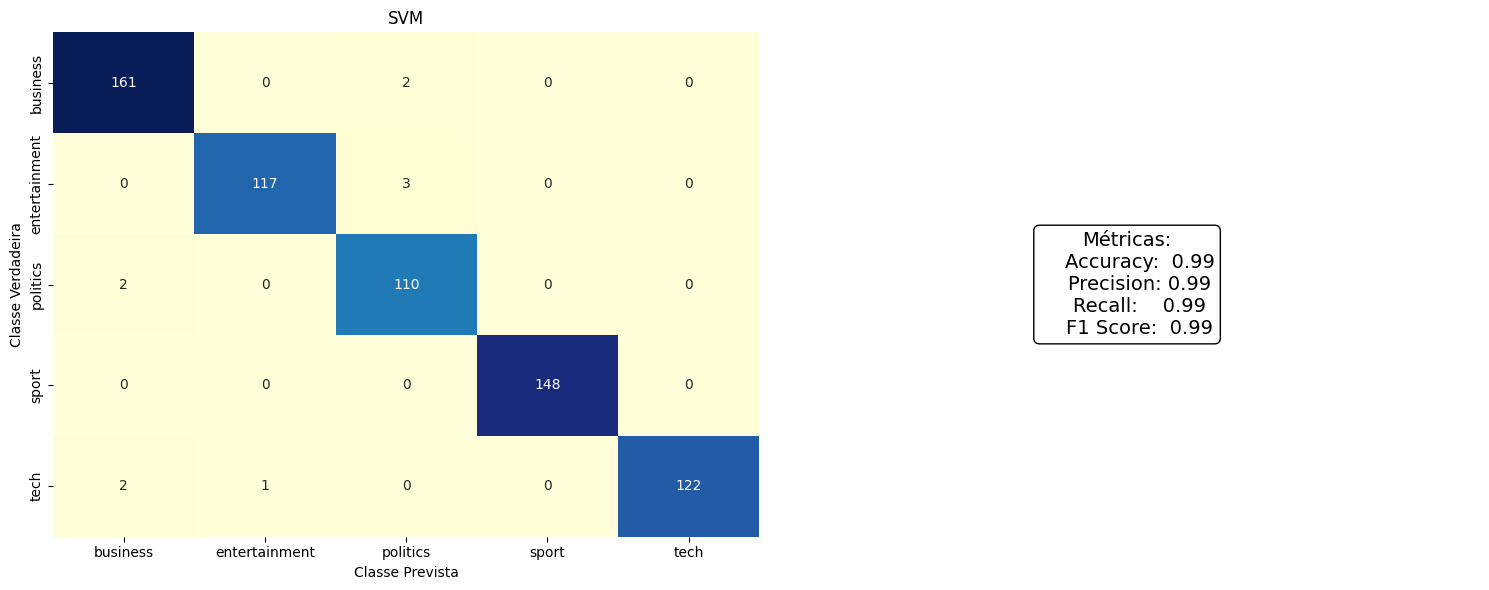

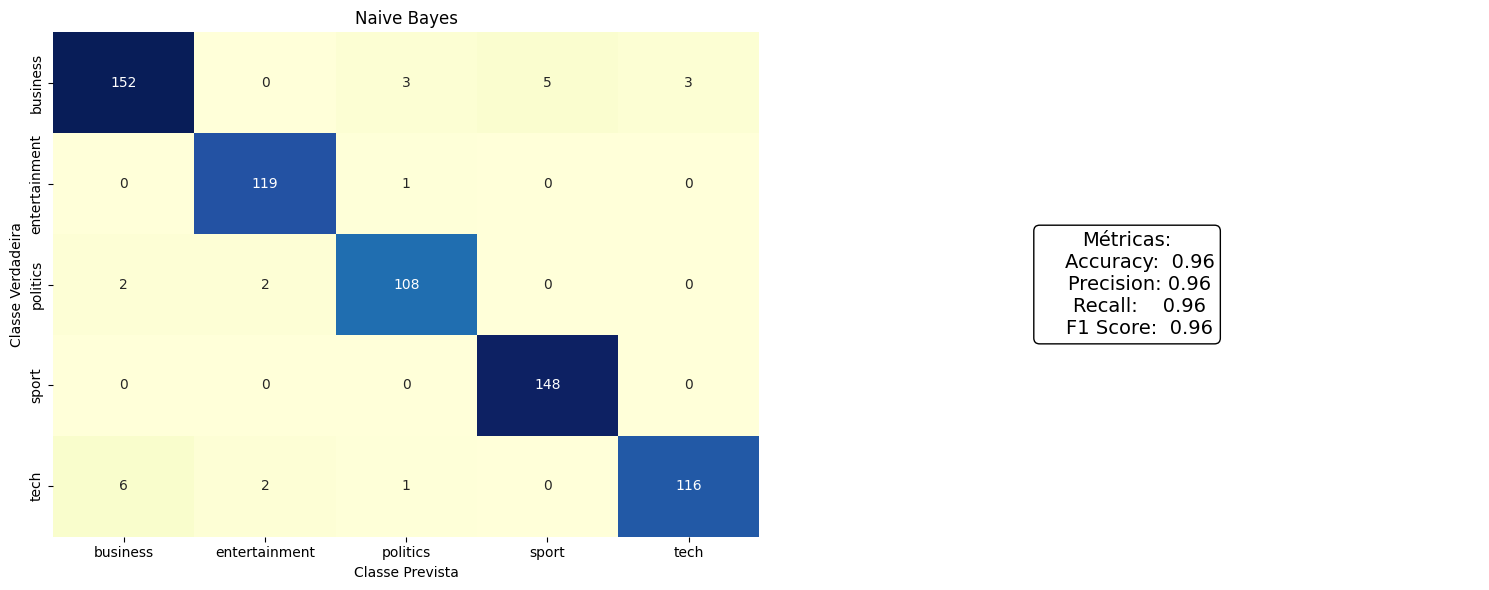

In [35]:
def metrics_describe(model, model_name):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # 1x2 grid
    
    # Classes
    classes = model.classes_
    
    # Matriz de Confusão
    sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt="d", cbar=False, ax=ax1, 
                xticklabels=classes, yticklabels=classes)
    ax1.set_title(f'{model_name}')
    ax1.set_xlabel('Classe Prevista')
    ax1.set_ylabel('Classe Verdadeira')
    
    # Métricas 
    metrics_text = f"""Métricas:
    Accuracy:  {accuracy:.2f}
    Precision: {precision:.2f}
    Recall:    {recall:.2f}
    F1 Score:  {f1:.2f}"""
    ax2.text(0.5, 0.5, metrics_text, fontsize=14, ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    ax2.axis('off')

    # Ajuste de layout
    plt.tight_layout()
    plt.show()

# O resto do código permanece o mesmo
def run_models():
    classifiers = {
        "Logistic Regression": LogisticRegression(),
        "SVM": LinearSVC(),
        "Naive Bayes": GaussianNB()
    }

    for model_name, model in classifiers.items():
        model.fit(X_train, y_train)
        metrics_describe(model, model_name)

# Chamando a função para rodar os modelos
run_models()

## Avaliação de Resultados

Os modelos de classificação (Regressão Logística, SVM e Naive Bayes) alcançaram alta acurácia ao classificar notícias da BBC em categorias distintas, com resultados em torno de 99% para os dois primeiros e 96% para o último. Esse desempenho elevado é explicado pela utilização de embeddings de texto gerados pelo BERT, que fornecem representações contextuais e semânticas robustas, facilitando a separação entre categorias simples e distintas. A base de dados, por sua vez, é relativamente fácil de classificar devido às categorias bem definidas e pouco ambíguas, o que contribui para os altos valores de acurácia.

| Modelo                | Acurácia | Precisão | Recall | F1 Score |
|-----------------------|----------|----------|--------|----------|
| Regressão Logística   | 0.99     | 0.99     | 0.99   | 0.99     |
| SVM                   | 0.99     | 0.99     | 0.99   | 0.99     |
| Naive Bayes           | 0.96     | 0.96     | 0.96   | 0.96     |

## <a name="modelagem-bertopic"></a>2. Modelagem de Tópicos com BERTopic

Explorando o **BERTopic**, aplicamos esta técnica que combina embeddings do BERT com algoritmos de clustering para identificar e analisar tópicos em um conjunto de dados textual. O foco está na extração dos tópicos e na visualização das palavras mais relevantes para cada grupo identificado.

**Conteúdos Abordados:**
- Aplicação do BERTopic para modelagem de tópicos.
- Extração e interpretação das palavras-chave associadas a cada tópico.
- Visualizações de tópicos, incluindo gráficos de barras e o método `visualize_topics()`.



### Pipeline do BERTopic

1. **Geração de Embeddings**: Utilização de BERT ou modelos semelhantes para converter documentos em vetores de alta dimensão.
2. **Redução de Dimensionalidade**: UMAP para reduzir o espaço dimensional dos embeddings e preservar proximidade semântica.
3. **Clustering de Embeddings**: HDBSCAN para agrupar documentos em tópicos e lidar com outliers.
4. **Identificação de Palavras-Chave**: Uso de TF-IDF para encontrar palavras representativas para cada tópico.
5. **Visualização dos Tópicos**: Ferramentas de visualização interativa para explorar e interpretar os tópicos. 


![](../data/pipelineBerTopic.png)

### 2.1 Geração de Embeddings

In [16]:
# model_name = "sentence-transformers/all-MiniLM-L6-v2"
# tokenizer = trf.AutoTokenizer.from_pretrained(model_name)
# model = trf.AutoModel.from_pretrained(model_name)


# encodings = tokenizer(bbc_df["data"].tolist(), padding=True, truncation=True, return_tensors="pt")
# input_ids = encodings['input_ids']
# attention_mask = encodings['attention_mask']

# # Criar DataLoader para processamento em batches
# dataset = TensorDataset(input_ids, attention_mask)
# dataloader = DataLoader(dataset, batch_size=batch_size)

# # Processar os batches e gerar os embeddings
# all_embeddings = []
# with torch.no_grad():
#     for batch in dataloader:
#         batch_input_ids, batch_attention_mask = batch
#         outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
#         # Extrair os embeddings para cada batch e calcular a média para representar cada texto
#         batch_embeddings = outputs.last_hidden_state.mean(dim=1)
#         all_embeddings.append(batch_embeddings)

# # Concatenar os embeddings finais
# final_embeddings = torch.cat(all_embeddings, dim=0).cpu().numpy()

# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(bbc_df["data"].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 70/70 [02:03<00:00,  1.76s/it]


### 2.2 Redução de Dimensionalidade

In [6]:
#embeddings = np.load("../data/final_embeddings_2.1.npy")
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

### 2.3 Clustering de Embeddings

In [4]:
hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

### 2.4 Identificação de Palavras-Chave

In [17]:
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model,
    "POS": pos_model
}

topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

topics, probs = topic_model.fit_transform(bbc_df["data"].tolist(), embeddings=embeddings)

2024-11-04 17:31:06,611 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-04 17:31:15,210 - BERTopic - Dimensionality - Completed ✓
2024-11-04 17:31:15,211 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-04 17:31:15,338 - BERTopic - Cluster - Completed ✓
2024-11-04 17:31:15,341 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-04 17:31:27,604 - BERTopic - Representation - Completed ✓


### 2.5 Visualização dos Tópicos

In [18]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,POS,Representative_Docs
0,-1,55,-1_yukos_oil_russian_said,"[yukos, oil, russian, said, law, gazprom, hunt...","[yukos, yushchenko, russian oil, yugansknefteg...","[yukos, gazprom, hunt, legal, russia, crude, p...","[oil, law, hunting, court, auction, hunt, lega...",[Yukos accused of lying to court Russian oil ...
1,0,798,0_said_people_film_music,"[said, people, film, music, new, best, year, m...","[digital, technology, mobile, tv, phones, micr...","[said, music, year, mobile, technology, tv, us...","[people, film, music, new, best, year, mobile,...",[Roundabout continues nostalgia trip The new ...
2,1,433,1_said_year_growth_economy,"[said, year, growth, economy, market, sales, e...","[markets, rates, economy, financial, market, d...","[growth, economy, market, prices, firms, analy...","[year, growth, economy, market, sales, economi...",[Bank holds interest rate at 4.75% The Bank o...
3,2,416,2_mr_said_election_labour,"[mr, said, election, labour, government, blair...","[mr blair, tony blair, blair, tory, mr brown, ...","[labour, blair, people, mr blair, told, tory, ...","[election, labour, government, party, people, ...",[Blair and Brown criticised by MPs Labour MPs...
4,3,335,3_england_game_club_said,"[england, game, club, said, wales, players, ha...","[england, rugby, ireland, wales, irish, refere...","[said, wales, players, rugby, chelsea, coach, ...","[game, club, players, half, win, cup, rugby, t...",[Campese berates whingeing England Former Aus...
5,4,188,4_world_champion_year_said,"[world, champion, year, said, olympic, open, s...","[wimbledon, tennis, holmes, doping, olympic, c...","[champion, olympic, athens, won, australian, m...","[world, champion, year, set, win, final, race,...",[Gardener battles to narrow win Jason Gardene...


In [19]:
topic_model.get_topic(1, full=True)

{'Main': [('said', 0.04152854649996946),
  ('year', 0.026298455401239915),
  ('growth', 0.022390430646211615),
  ('economy', 0.020485549781900383),
  ('market', 0.019875247673948437),
  ('sales', 0.01771511802333464),
  ('economic', 0.017605432223890004),
  ('bank', 0.01725315331648539),
  ('company', 0.01711742047566744),
  ('mr', 0.016612653669835175)],
 'KeyBERT': [('markets', 0.35440174),
  ('rates', 0.34472007),
  ('economy', 0.33901),
  ('financial', 0.3243849),
  ('market', 0.3137239),
  ('demand', 0.3085818),
  ('banks', 0.29243103),
  ('deficit', 0.28956014),
  ('bank', 0.28950787),
  ('rate', 0.2887476)],
 'MMR': [('growth', 0.022390430646211615),
  ('economy', 0.020485549781900383),
  ('market', 0.019875247673948437),
  ('prices', 0.012468868535159187),
  ('firms', 0.011878655891429073),
  ('analysts', 0.011853175795315042),
  ('oil', 0.011493276109061147),
  ('financial', 0.011261699158553552),
  ('2005', 0.010932433620196729),
  ('stock', 0.010862477225799956)],
 'POS': [(

In [20]:
topic_model.visualize_topics(custom_labels=True)

In [21]:
topic_model.visualize_hierarchy(custom_labels=True)

In [26]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(bbc_df["labels"].tolist(), reduced_embeddings=reduced_embeddings, custom_labels=True)

## <a name="engenharia-prompt"></a>3. Engenharia de Prompt para Extração de Entidades Nomeadas

Nesta seção, estudamos a **engenharia de prompt** para identificar entidades nomeadas específicas usando grandes modelos de linguagem, como o ChatGPT. A proposta é criar prompts direcionados para extração de entidades, utilizando o conceito de few-shot learning, que permite uma adaptação rápida sem necessidade de ajuste fino dos pesos do modelo.

**Conteúdos Abordados:**
- Desenvolvimento de prompts para extração de entidades.
- Aplicação prática dos prompts em textos e análise dos resultados.
- Discussão sobre a eficácia da abordagem de few-shot learning em modelos de linguagem.

### Identificação de Entidades em Texto

A tarefa consiste em identificar entidades específicas em um texto. As entidades a serem extraídas incluem:

- **Pessoa**: Nomes de indivíduos.
- **Local**: Cidades, países, regiões ou locais geográficos.
- **Organização**: Empresas, instituições ou outros tipos de organizações.
- **Data**: Datas importantes ou períodos de tempo.

### **Modelo Utilizado**: ChatGPT-4

#### Exemplos

#### Exemplo 1
**Texto**: "John trabalha na OpenAI em São Francisco desde 2020."  
**Entidades**:
- Pessoa: "John"
- Organização: "OpenAI"
- Local: "São Francisco"
- Data: "2020"

#### Exemplo 2
**Texto**: "O evento ocorrerá em Nova York na próxima segunda-feira."  
**Entidades**:
- Local: "Nova York"
- Data: "próxima segunda-feira"

#### Exemplo 3
**Texto**: "A Apple foi fundada por Steve Jobs e está sediada em Cupertino."  
**Entidades**:
- Organização: "Apple"
- Pessoa: "Steve Jobs"
- Local: "Cupertino"

#### Exemplo 4
**Texto**: "A conferência da ONU será realizada em Genebra em março de 2023."  
**Entidades**:
- Organização: "ONU"
- Local: "Genebra"
- Data: "março de 2023"

#### Exemplo 5
**Texto**: "Elon Musk anunciou novos planos para o Twitter em 2022."  
**Entidades**:
- Pessoa: "Elon Musk"
- Organização: "Twitter"
- Data: "2022"

#### Exemplo Considerado

#### Texto 1
**Texto**: "Angela Merkel visitou a sede da ONU em Nova York em setembro de 2021."  
**Entidades**:

![Imagem do print aqui](../data/prompt_ex1.png)

---
#### Texto 2
**Texto**: "O Google anunciou uma nova atualização no evento realizado em Londres."  
**Entidades**:

![Imagem do print aqui](../data/prompt_ex2.png)





## <a name="fine-tuning-gpt2"></a>4. Fine-tuning com GPT-2 para Geração de Textos

Por último, exploramos o fine-tuning do modelo **GPT-2** para a tarefa de geração de textos. A técnica envolve o treinamento do GPT-2 em uma base de dados específica, seguido pela geração de textos completos a partir de entradas iniciais, como tags ou palavras sugeridas.

**Conteúdos Abordados:**
- Procedimento de fine-tuning do GPT-2 usando o framework da Hugging Face.
- Treinamento do modelo com um corpus específico.
- Geração de textos baseados em condições iniciais e interpretação dos resultados.